In [1]:
from microstruktur.signal_models.cylinder_models import C4CylinderGaussianPhaseApproximation
from microstruktur.core.modeling_framework import MultiCompartmentModel
from microstruktur.signal_models import distribute_models
from microstruktur.signal_models.gaussian_models import G3Ball
from microstruktur.data import saved_acquisition_schemes, saved_data

In [2]:
scheme_spinal_cord, data_spinal_cord = saved_data.duval_cat_spinal_cord_2d()

This data was used by Duval et al. 'Validation of quantitative MRI metrics using full slice histology with automatic axon segmentation', ISMRM 2016. Reference at http://indexsmart.mirasmart.com/ISMRM2016/PDFfiles/0928.html


In [3]:
scheme_spinal_cord.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1791
number of b0 measurements: 72
number of DWI shells: 9

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |199       |886             |0                        |3.0        |7.0       |36.152
1           |199       |5762            |0                        |3.0        |40.0      |57.288
2           |199       |9806            |0                        |8.0        |12.0      |46.152
3           |199       |12958           |0                        |8.0        |15.0      |46.152
4           |199       |18212           |0                        |8.0        |20.0      |46.152
5           |199       |23465           |0                        |8.0        |25.0      |47.288
6           |199       |28719           |0                        |8.0        |30.0      |52.288
7           |199       |33972           |0                        |8.0        |35.0      |57.288
8        

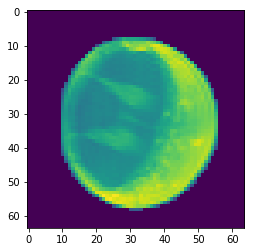

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data_spinal_cord.signal[:,:,0,0])

## AxCaliber Without Gamma Distribution

In [6]:
cylinder = C4CylinderGaussianPhaseApproximation()
ball = G3Ball()

axcaliber = MultiCompartmentModel(scheme_spinal_cord, models=[ball, cylinder])
axcaliber.optimized_parameters['C4CylinderGaussianPhaseApproximation_1_mu'] = False
axcaliber.optimized_parameters['C4CylinderGaussianPhaseApproximation_1_lambda_par'] = False

parameter_x0 = axcaliber.parameter_initial_guess_to_parameter_vector(
    C4CylinderGaussianPhaseApproximation_1_mu = [0, 0],
    C4CylinderGaussianPhaseApproximation_1_lambda_par=1.7e-9)

C4CylinderGaussianPhaseApproximation_1_mu successfully set.
C4CylinderGaussianPhaseApproximation_1_lambda_par successfully set.


In [7]:
axcaliber_fit = axcaliber.fit(data_spinal_cord.signal, mask=data_spinal_cord.mask,
                     parameter_initial_guess=parameter_x0,
                     use_parallel_processing=True, number_of_processors=8, Ns=5)

Using parallel processing with 8 workers.
Starting fitting process
Fitting of 968 voxels complete in 182.003793955 seconds.
Average of 0.1880204483 seconds per voxel.


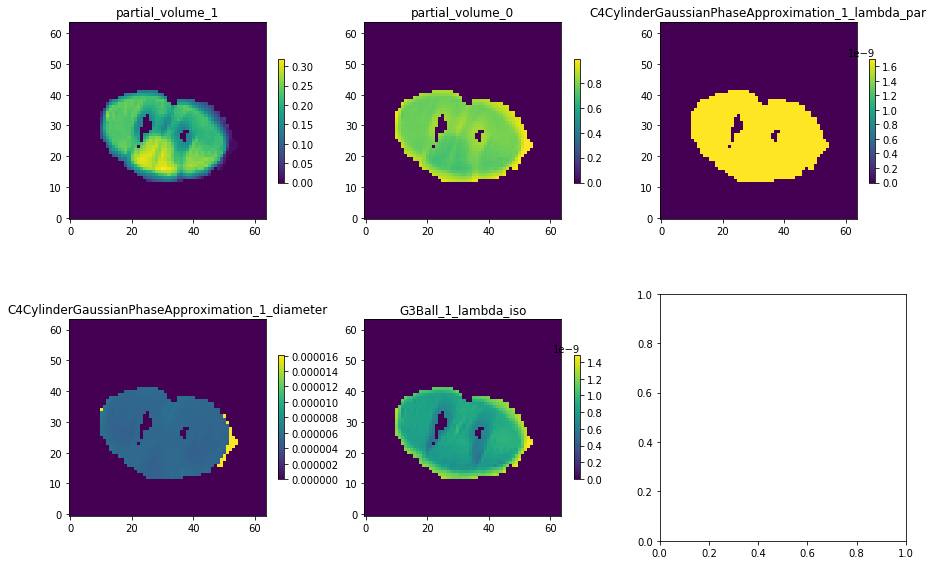

In [8]:
fitted_parameters = axcaliber_fit.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

## AxCaliber with Gamma Distribution

In [9]:
cylinder = C4CylinderGaussianPhaseApproximation()
ball = G3Ball()
gamma_cylinder = distribute_models.DD1GammaDistributed(models=[cylinder])

In [11]:
axcaliber_gamma = MultiCompartmentModel(scheme_spinal_cord, models=[G3Ball(), gamma_cylinder])
axcaliber_gamma.optimized_parameters['DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu'] = False
axcaliber_gamma.optimized_parameters['DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par'] = False

In [13]:
parameter_x0 = axcaliber_gamma.parameter_initial_guess_to_parameter_vector(
    DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu = [0, 0],
    DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par=1.7e-9)

DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu successfully set.
DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par successfully set.


In [32]:
# takes super long but at least the solution is good..
axcaliber_gamma_fit = axcaliber_gamma.fit(
                     data, mask=data[..., 0]>0,
                     parameter_initial_guess=parameter_x0,
                     solver='mix',
                     maxiter=10)

Using parallel processing with 8 workers.
Starting fitting process
Fitting of 8 voxels complete in 117.531110048 seconds.
Average of 14.691388756 seconds per voxel.


In [33]:
path = '/user/rfick/home/microstruktur/microstruktur/data/tanguy_cat_spinal_cord/4_fr.nii'

In [34]:
import nibabel as nib

In [37]:
test = nib.load(path).get_data()

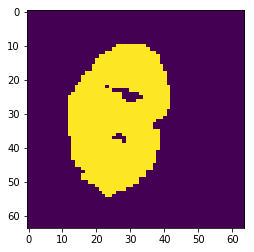

In [40]:
plt.imshow(test>0)